# Predicting COVID-19 cases with X-Ray imaging

Data provided by M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145.

## Install required packages

In [ ]:
! pip install aimodelshare --upgrade --extra-index-url https://test.pypi.org/simple/ 

In [ ]:
# note that tabular preprocessors require scikit-learn>=0.24.0
# Newest Tensorflow 2 has some bugs for onnx conversion
!pip install scikit-learn --upgrade 
import os
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1.4

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import zipfile
from mpl_toolkits.axes_grid1 import ImageGrid

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D

## Loading required data

In [ ]:
# Download and unzip data
!gdown --id 1xt7g5LkZuX09e1a8rK9sRXIrGFN6rjzl
!unzip COVID-19_Radiography_Database.zip

In [ ]:
# Extracting all filenames iteratively
base_path = 'COVID-19 Radiography Database'
categories = ['COVID', 'NORMAL', 'Viral Pneumonia']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [1200, 1341, 1345]
[['COVID-19 Radiography Database/COVID/COVID (996).png', 'COVID-19 Radiography Database/COVID/COVID (132).png', 'COVID-19 Radiography Database/COVID/COVID (571).png', 'COVID-19 Radiography Database/COVID/COVID (100).png', 'COVID-19 Radiography Database/COVID/COVID (945).png', 'COVID-19 Radiography Database/COVID/COVID (838).png', 'COVID-19 Radiography Database/COVID/COVID (12).png', 'COVID-19 Radiography Database/COVID/COVID (272).png', 'COVID-19 Radiography Database/COVID/COVID (575).png', 'COVID-19 Radiography Database/COVID/COVID (902).png', 'COVID-19 Radiography Database/COVID/COVID (518).png', 'COVID-19 Radiography Database/COVID/COVID (350).png', 'COVID-19 Radiography Database/COVID/COVID (441).png', 'COVID-19 Radiography Database/COVID/COVID (621).png', 'COVID-19 Radiography Database/COVID/COVID (856).png', 'COVID-19 Radiography Database/COVID/COVID (250).png', 'COVID-19 Radiography Database/COVID/COVID (219).png', 'COVID-19

## Preprocessing

In [ ]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
# Uses opencv for image preprocessing

def preprocessor(data, shape=(192, 192)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.  

        # Resize the images.
        X = np.array(img)
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

In [ ]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [ ]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min() ) #min value of every image is zero
print(X.max() ) #max value of every image is one

3886
(3886, 192, 192, 3)
0.0
1.0


In [ ]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1200))
normal=list(repeat("NORMAL", 1341))
pneumonia=list(repeat("PNEUMONIA", 1345))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1200, 1341, 1345]
3886


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
3881,0,0,1
3882,0,0,1
3883,0,0,1
3884,0,0,1


In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)

print('Shape of X train',X_train.shape)
print('Shape of y train',y_train.shape)

Shape of X train (3108, 192, 192, 3)
Shape of y train (3108, 3)


## Exploratory analysis

In [ ]:
# Gather samples
print(fnames[1][0:2])
print(fnames[0][0:2])
print(fnames[2][0:2])

['COVID-19 Radiography Database/NORMAL/NORMAL (1148).png', 'COVID-19 Radiography Database/NORMAL/NORMAL (349).png']
['COVID-19 Radiography Database/COVID/COVID (996).png', 'COVID-19 Radiography Database/COVID/COVID (132).png']
['COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1083).png', 'COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (620).png']


In [ ]:
# Obtain preprocessed images
im_covid = preprocessor('COVID-19 Radiography Database/COVID/COVID (513).png'), preprocessor('COVID-19 Radiography Database/COVID/COVID (700).png')
im_normal = preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (969).png'), preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (25).png')
im_pneumonia = preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (306).png'), preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (862).png')

#### COVID-19 X-Ray

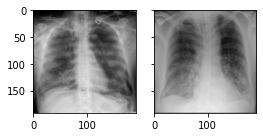

In [ ]:
# Plot sample imagery
fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im_covid[0], im_covid[1]]):
    ax.imshow(im)
plt.show()

#### Normal X-Ray

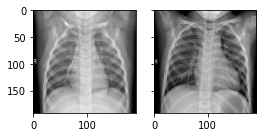

In [ ]:
# Plot sample imagery
fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im_normal[0], im_normal[1]]):
    ax.imshow(im)
plt.show()

#### Pneumonia X-Ray

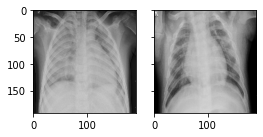

In [ ]:
# Plot sample imagery
fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im_pneumonia[0], im_pneumonia[1]]):
    ax.imshow(im)
plt.show()

**Discussion**: In this dataset, we have 1200 X-Rays of positive COVID-19 cases, 1341 images of normal lungs, and 1345 images of lungs with viral pneumonia. After preprocessing, this imagery has an individual size of 192 pixels by 192 pixels, with 3 channels (red, green and blue). The six images show different categories of X-Rays. We can observe that normal X-Ray images show lungs with definite borders, as opposed to COVID-19 positive cases where the borders are diffuse.

Given the impact of ongoing pandemic, early and fast screening is a powerful tool to identify COVID-19 positive cases. Powered by ML, a model that uses X-Rays can become a fast, cheap, and accurate screening tool. Compared to current methods, a ML system based on X-Rays can help physicians to diagnose a positive case at an early stage and prevent COVID-19 damages from getting worse.

## Model building

## Model 1: Sequential model with Max Pooling and softmax in last layer

#### Training model

In [ ]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 5 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 3, verbose=1,validation_data=(X_test,y_test)) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 3108 samples, validate on 778 samples
Epoch 1/3
3108/3108 [==============================] - 17s 5ms/sample - loss: 0.5717 - acc: 0.7313 - val_loss: 0.3809 - val_acc: 0.8419
Epoch 2/3
3108/3108 [==============================] - 9s 3ms/sample - loss: 0.3057 - acc: 0.8845 - val_loss: 0.3192 - val_acc: 0.8779
Epoch 3/3
3108/3108 [==============================] - 9s 3ms/sample - loss: 0.2795 - acc: 0.8977 - val_loss: 0.2989 - val_acc: 0.8817


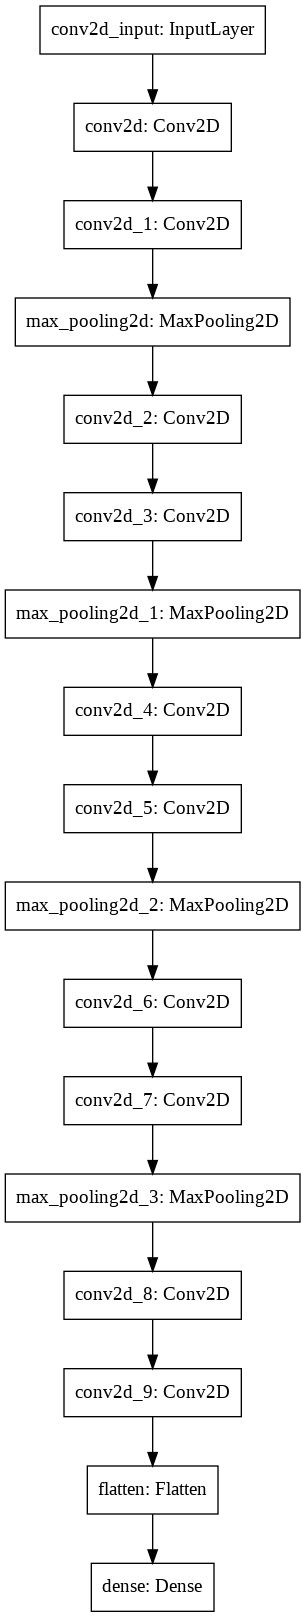

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
# model.summary()

#### Model performance

In [ ]:
# using predict_classes() for multi-class data to return predicted class index.
def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

prediction_index=predict_classes(model.predict(X_test))

In [ ]:
# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

In [ ]:
# Iterate through all predicted indices using map method
predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

['PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'COVID', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'COVID', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'COVID', 'PNEUMONIA', 'COVID', 'COVID', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'COVID', 'COVID', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'COVID', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'COVID', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'COVID',

In [ ]:
# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

In [ ]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test_labels=list(y_test.idxmax(axis=1)) #returns a pandas series of predicted labels

In [ ]:
# get metrics
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.881748,0.881542,0.898916,0.8848,0,0,0,0


## Model 2: Sequential model with Average Pooling and Sigmoid in last layer

#### Training model

In [ ]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.AveragePooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.AveragePooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.AveragePooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.AveragePooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.AveragePooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 5 categories
    tf.keras.layers.Dense(3, activation='sigmoid')
  ])

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test)) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Train on 3108 samples, validate on 778 samples
Epoch 1/5
3108/3108 [==============================] - 10s 3ms/sample - loss: 0.7061 - acc: 0.6728 - val_loss: 0.4299 - val_acc: 0.8432
Epoch 2/5
3108/3108 [==============================] - 10s 3ms/sample - loss: 0.3336 - acc: 0.8723 - val_loss: 0.3063 - val_acc: 0.8663
Epoch 3/5
3108/3108 [==============================] - 10s 3ms/sample - loss: 0.2673 - acc: 0.9041 - val_loss: 0.2281 - val_acc: 0.9190
Epoch 4/5
3108/3108 [==============================] - 10s 3ms/sample - loss: 0.2341 - acc: 0.9128 - val_loss: 0.2344 - val_acc: 0.9062
Epoch 5/5
3108/3108 [==============================] - 10s 3ms/sample - loss: 0.2293 - acc: 0.9125 - val_loss: 0.1922 - val_acc: 0.9332


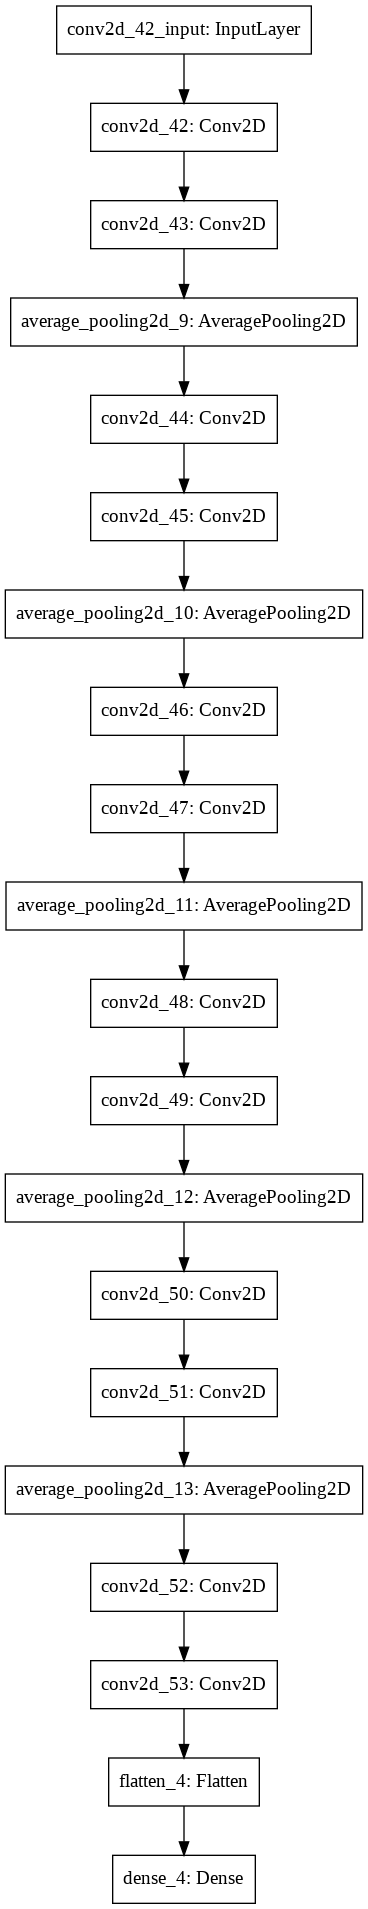

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
# model.summary()

#### Model performance

In [ ]:
# using predict_classes() for multi-class data to return predicted class index.
def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

prediction_index=predict_classes(model.predict(X_test))

In [ ]:
# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

In [ ]:
# Iterate through all predicted indices using map method
predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

['PNEUMONIA', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'PNEUMONIA', 'COVID', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'COVID', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'COVID', 'COVID', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'COVID', 'COVID', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'COVID', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'COVID', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', '

In [ ]:
# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

In [ ]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test_labels=list(y_test.idxmax(axis=1)) #returns a pandas series of predicted labels

In [ ]:
# get metrics
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.933162,0.934328,0.935588,0.933468,0,0,0,0


## Model 3: Transfer learning using architecture of InceptionV3 and adjusting for three labels

#### Training model

In [ ]:
# example of loading the Inception model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
# base_model.trainable = False

# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='sigmoid')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

#   model.compile(optimizer='adam',loss= 'categorical_crossentropy',metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 3, verbose=1,validation_data=(X_test,y_test))

Train on 3108 samples, validate on 778 samples
Epoch 1/3
3108/3108 [==============================] - 68s 22ms/sample - loss: 0.4648 - acc: 0.8514 - val_loss: 0.5170 - val_acc: 0.8021
Epoch 2/3
3108/3108 [==============================] - 50s 16ms/sample - loss: 0.1097 - acc: 0.9681 - val_loss: 0.1723 - val_acc: 0.9396
Epoch 3/3
3108/3108 [==============================] - 51s 16ms/sample - loss: 0.0805 - acc: 0.9755 - val_loss: 0.0991 - val_acc: 0.9704


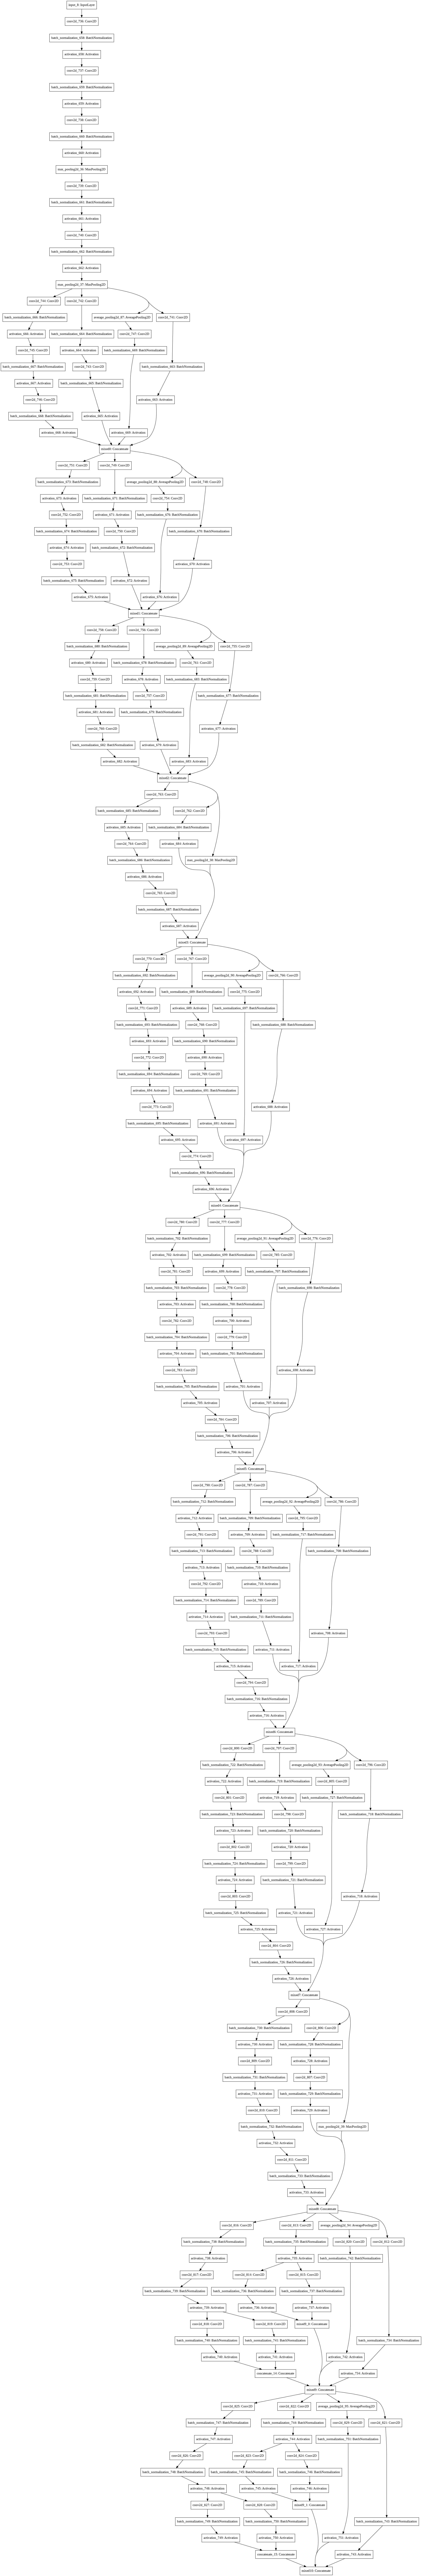

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(base_model, to_file='model.png')
# model.summary()

#### Model performance

In [ ]:
# using predict_classes() for multi-class data to return predicted class index.
def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

prediction_index=predict_classes(model.predict(X_test))

In [ ]:
# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

In [ ]:
# Iterate through all predicted indices using map method
predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

['PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'COVID', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'COVID', 'COVID', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'COVID', 'COVID', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'COVID', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'COVID', 'PNEUMONIA', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'COVID', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA', 'NORMAL', 'COVID', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA',

In [ ]:
# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

In [ ]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test_labels=list(y_test.idxmax(axis=1)) #returns a pandas series of predicted labels

In [ ]:
# get metrics
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.970437,0.971197,0.971771,0.970751,0,0,0,0


## Publising best model to AI Model Share

**Discussion**: The first model uses Max Pooling to down sample the feature maps between the convolutional layers and softmax as the activation function in the last dense layer. This model produces a F1 score of 0.88. By modifing the pooling methods to Average Pooling, the computing time reduces drastically, and by changing the activation function to the Sigmoid, the F1 score increases to 0.93. Given that sigmoid estimates the probability on an individual basis, so the sum of the probabilities for all 3 classes is not 1 (as opposed to Softmax), sigmoid function works well with multi-labeled data. In this case, some Viral Pneumonia cases can also be affected by COVID-19, so by relaxing the constraint of exclusive classes, the F1 score can improve.
Finally, I used a transfer learning approach with InceptionV3, which after adjusting the last layer to get three classes with the sigmoid function, we obtain 0.97 as F1 score.

### Prepare publish

In [ ]:
import os
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

### Save model to onnx

In [ ]:
# Save sklearn model to onnx file
import aimodelshare as ai
from aimodelshare.aimsonnx import model_to_onnx

# transform sklearn model to ONNX
onnx_model_keras= model_to_onnx(model, framework='keras', 
                                   transfer_learning=True,
                                   deep_learning=True,
                                   task_type='classification')

# Save model to local .onnx file
with open("onnx_model_keras.onnx", "wb") as f:
    f.write(onnx_model_keras.SerializeToString())

The ONNX operator number change on the optimization: 831 -> 223


### Authenticate to AI Model Share

In [7]:
# Set credentials to submit new model/preprocessor

from aimodelshare.aws import set_credentials
set_credentials(credential_file="credentials.txt", type="submit_model", apiurl="https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m") #Covid image prediction apiURL

token=ai.aws.get_aws_token(os.environ.get("username"), os.environ.get("password"))
awscreds=ai.aws.get_aws_client(aws_key=os.environ.get('AWS_ACCESS_KEY_ID'), aws_secret=os.environ.get('AWS_SECRET_ACCESS_KEY'), aws_region=os.environ.get('AWS_REGION'))

AI Model Share login credentials set successfully.
AWS credentials set successfully.


### Submit model

In [ ]:
# Submit_model() to leaderboard
ai.submit_model("onnx_model_keras.onnx",
                "https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,prediction_submission=predicted_labels,
                preprocessor="preprocessor.zip")

'Your model has been submitted as model version 22'

In [8]:
# Check leaderboard
import pandas
data=ai.get_leaderboard("https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,verbose=2)

In [9]:
ai.stylize_leaderboard(data, category="classification")
# data[data['username']=='mro9395']

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,activation_layers,add_layers,averagepooling2d_layers,batchnormalization_layers,concatenate_layers,conv2d_layers,dense_layers,flatten_layers,globalaveragepooling2d_layers,inputlayer_layers,maxpooling2d_layers,zeropadding2d_layers,loss,optimizer,model_config,username,version
0,98.59%,98.61%,98.65%,98.58%,keras,True,True,Model,22,33593155,nan,nan,nan,nan,nan,13.000000,2,1.000000,nan,1.000000,5.000000,nan,str,Adam,"{'name': 'model_2', 'layers': ...",kagenlim,7
1,98.59%,98.61%,98.65%,98.58%,keras,True,True,Model,22,33593155,nan,nan,nan,nan,nan,13.000000,2,1.000000,nan,1.000000,5.000000,nan,str,Adam,"{'name': 'model_2', 'layers': ...",kagenlim,8
2,98.07%,98.11%,98.12%,98.13%,keras,False,True,Model,26,39162947,nan,nan,nan,nan,nan,16.000000,3,1.000000,nan,1.000000,5.000000,nan,str,Adam,"{'name': 'model_12', 'layers':...",dv2438,26
3,97.04%,97.12%,97.18%,97.08%,keras,True,True,Model,313,21808931,94.000000,nan,9.000000,94.000000,15.000000,94.000000,1,nan,1.000000,1.000000,4.000000,nan,str,SGD,"{'name': 'model_6', 'layers': ...",mro9395,22
4,97.04%,97.12%,97.18%,97.08%,keras,False,True,Model,313,21808931,94.000000,nan,9.000000,94.000000,15.000000,94.000000,1,nan,1.000000,1.000000,4.000000,nan,str,SGD,"{'name': 'model_6', 'layers': ...",mro9395,18
5,97.04%,97.08%,97.17%,97.13%,keras,True,True,Model,34,20232011,nan,nan,nan,3.000000,1.000000,20.000000,2,1.000000,1.000000,1.000000,5.000000,nan,str,Adam,"{'name': 'model_15', 'layers':...",dv2438,28
6,96.92%,96.99%,96.98%,97.01%,keras,True,True,Sequential,4,7082307,nan,nan,nan,nan,nan,nan,3,1.000000,nan,nan,nan,nan,str,SGD,"{'name': 'sequential_1', 'laye...",xcin,23
7,96.14%,96.20%,96.15%,96.28%,keras,True,True,Sequential,4,7082307,nan,nan,nan,nan,nan,nan,3,1.000000,nan,nan,nan,nan,str,SGD,"{'name': 'sequential', 'layers...",xcin,29
8,95.89%,95.93%,96.01%,95.87%,keras,True,True,Sequential,16,41083,nan,nan,nan,nan,nan,10.000000,1,1.000000,nan,nan,4.000000,nan,str,Adam,"{'name': 'sequential', 'layers...",mikedparrott,2
9,95.63%,95.74%,95.76%,95.74%,keras,True,True,Sequential,4,7082307,nan,nan,nan,nan,nan,nan,3,1.000000,nan,nan,nan,nan,str,SGD,"{'name': 'sequential', 'layers...",xcin,31
